 <span style="font-family: Arial; color:green; font-size:1.6em; font-weight:bold" >__A Gentle Introduction to Threshold-Moving for Imbalanced Classification__</span>

Tutorial for improve skills: 'A Gentle Introduction to Threshold-Moving for Imbalanced Classification' (from Machine Learning Mastery) by Marcus Mariano

**For more information about Marcus Mariano: [Web site](https://marcusmariano.github.io/mmariano/)**  

**A Gentle Introduction to Threshold-Moving for Imbalanced Classification: [Machine Learning Mastery](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)**

## Import Packages

In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

## Set parameters

In [65]:
N_THREADS = 6 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
N_JOBS = -1
SEED = 0 # fixed random state for various reasons
TEST_SIZE = 0.3 # Test size for metric check
VERBOSE = 1
TIMEOUT = 600 # Time in seconds for automl run, 600 seconds = 10 minutes
RAM = 7 #  Number of RAM limit
CPU_LIMIT = 4 # Number of CPU limit
TARGET_NAME = 'y'

## Load Datasets

In [5]:
from sklearn.datasets import make_classification

# generate dataset
X, y = make_classification(n_samples=10000, 
                           n_features=2, 
                           n_redundant=0,
                           n_clusters_per_class=1, 
                           weights=[0.99], 
                           flip_y=0, 
                           random_state=SEED)

print(X.shape, y.shape)

(10000, 2) (10000,)


In [19]:
data = pd.DataFrame(X, columns=["col_1", "col_2"])
data['y'] = y
data.head()

,col_1,col_2,y
0,0.586681,-1.567120,0
1,0.915990,-1.300678,0
2,1.101645,-1.061435,0
3,0.977691,-1.149823,0
4,0.891530,-1.052294,0


# Exploratory Data Analysis (EDA)


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col_1   10000 non-null  float64
 1   col_2   10000 non-null  float64
 2   y       10000 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 195.4 KB


## Plot

In [26]:
cols_num = [col for col in data.select_dtypes(include="number").columns if col not in [TARGET_NAME]]
print(len(cols_num))
cols_num

2


['col_1', 'col_2']

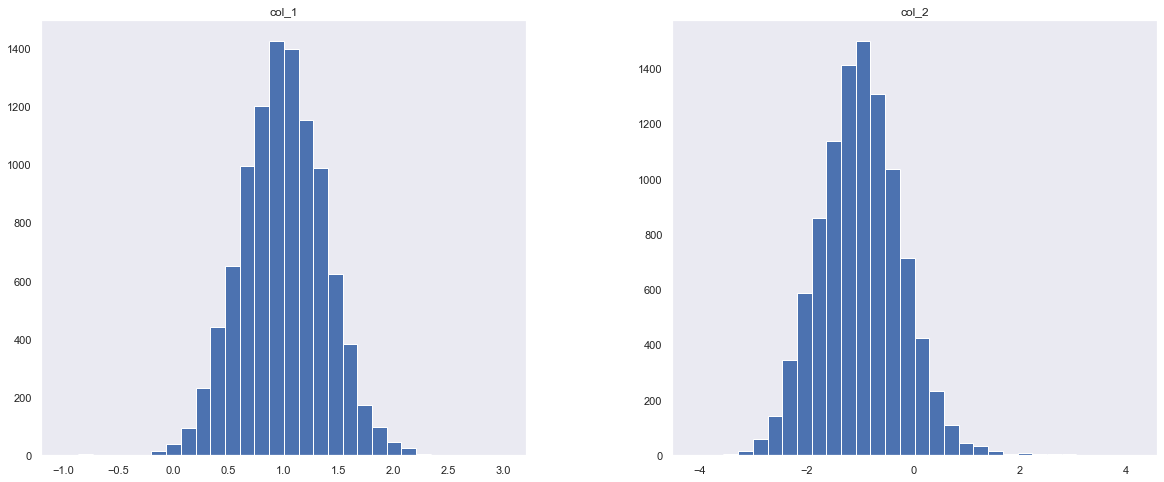

In [15]:
data[cols_num].hist(grid=False,
                    figsize=(20, 8),
                    bins=30);

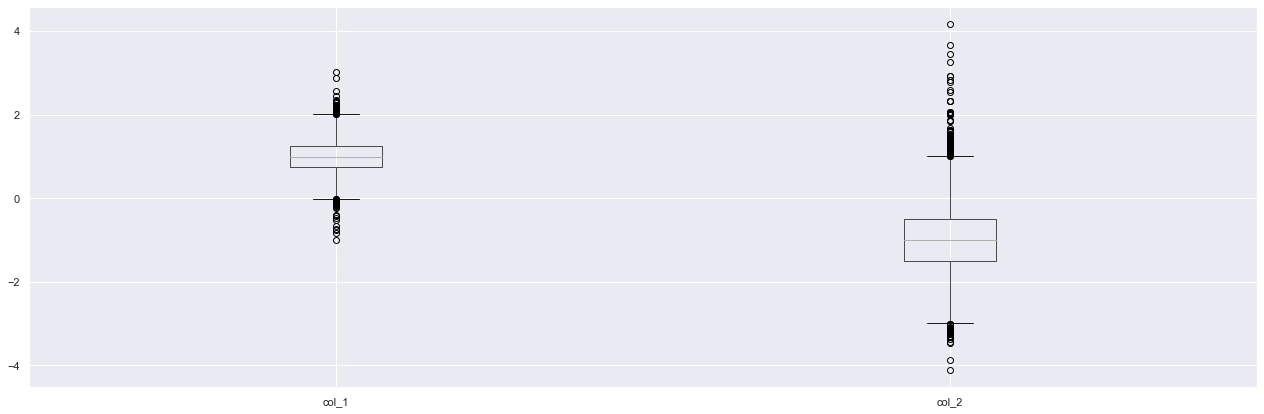

In [16]:
data[cols_num].boxplot(grid=True,
                       figsize=(22, 7));

In [7]:
print(f"Count 0: {list(y).count(0)}")
print(f"Count 1: {list(y).count(1)}")

print(f"\nPercent of 1: {list(y).count(1)  / (list(y).count(0) + list(y).count(1))}")

Count 0: 9900
Count 1: 100

Percent of 1: 0.01


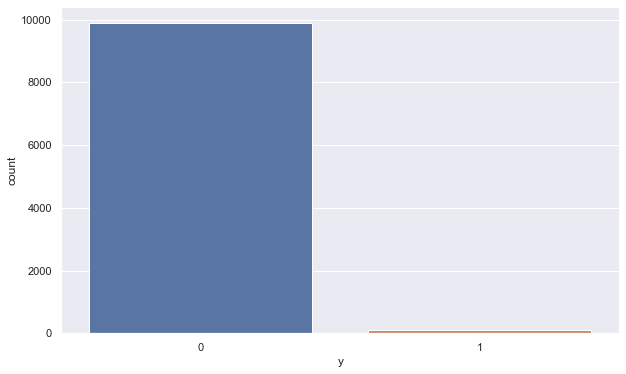

In [20]:
fig = plt.subplots(figsize=(10, 6))
sns.countplot(x=TARGET_NAME, data=data);

## Division of training and validation databases

In [28]:
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y, 
                                                      test_size=TEST_SIZE, 
                                                      random_state=SEED) 


print(f"Train 70%, Valid 30% data: {X_train.shape, X_valid.shape}",\
                                    y_train.shape, y_valid.shape)

Train 70%, Valid 30% data: ((7000, 2), (3000, 2)) (7000,) (3000,)


# LogisticRegression

In [33]:
from sklearn.linear_model import LogisticRegression
# fit a model
lr = LogisticRegression(solver='lbfgs')

lr.fit(X_train, y_train)
# predict probabilities
probs_lr = lr.predict_proba(X_valid)
# keep probabilities for the positive outcome only
probs_lr[:, 1]


array([0.00114409, 0.00129662, 0.00054137, ..., 0.00167629, 0.01038529,
       0.00013888])

In [35]:
from sklearn.metrics import roc_auc_score

lr_auc = roc_auc_score(y_valid, probs_lr[:, 1])
lr_auc

0.9443326626425218

## roc curve for logistic regression model

fprndarray of shape (>2,)

    Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i].

tprndarray of shape (>2,)

    Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].

thresholdsndarray of shape = (n_thresholds,)

    Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1

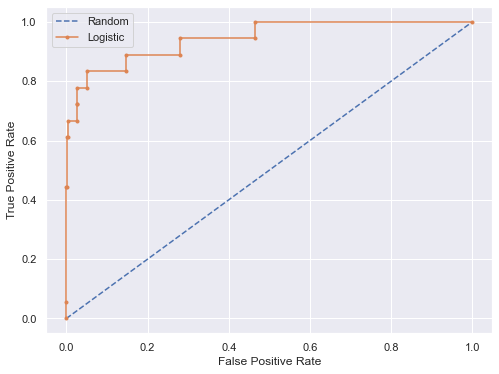

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, probs_lr[:, 1])

# plot the roc curve for the model
plt.figure(figsize=(8, 6))
plt.plot([0,1], [0,1], linestyle='--', label='Random')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt;

## roc curve for logistic regression model with optimal threshold

Best Threshold: 0.021933663884178202, G-Mean: 0.889


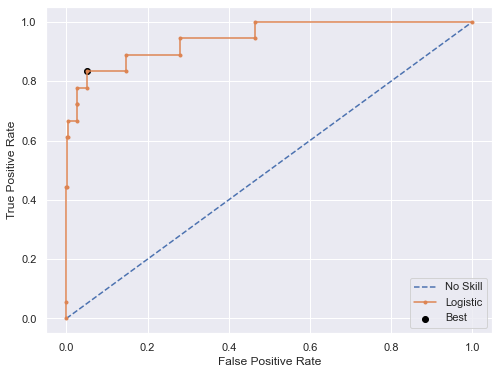

In [45]:
from sklearn.metrics import roc_curve

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)

print(f'Best Threshold: {thresholds[ix]}, G-Mean: {gmeans[ix]:.3f}')

# plot the roc curve for the model
plt.figure(figsize=(8, 6))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt;

## Youden’s J statistic

It turns out there is a much faster way to get the same result, called the __Youden’s J statistic__.

The statistic is calculated as:

    J = Sensitivity + Specificity – 1

Given that we have Sensitivity (TPR) and the complement of the specificity (FPR), we can calculate it as:

    J = Sensitivity + (1 – FalsePositiveRate) – 1

Which we can restate as:

    J = TruePositiveRate – FalsePositiveRate


In [48]:
from sklearn.metrics import roc_curve

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid, probs_lr[:, 1])
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print(f'Best Threshold: {best_thresh}')

Best Threshold: 0.021933663884178202


# Optimal Threshold for Precision-Recall Curve

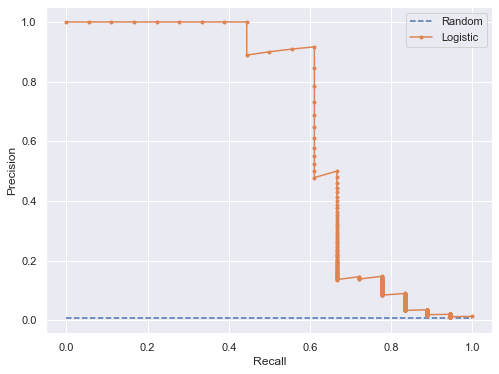

In [51]:
from sklearn.metrics import precision_recall_curve

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_valid, probs_lr[:, 1])

no_skill = len(y_valid[y_valid==1]) / len(y_valid)

# plot the roc curve for the model
plt.figure(figsize=(8, 6))
plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='Random')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt;

## Best balance of precision and recall

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the F1 Score that summarizes the harmonic mean of both measures.

    F1 Score = (2 * Precision * Recall) / (Precision + Recall)

As in the previous section, the naive approach to finding the optimal threshold would be to calculate the F1 Score for each threshold. We can achieve the same effect by converting the precision and recall measures to F1 Score directly; for example:

Best Threshold: 0.33590687525158636, F1-Score: 0.733


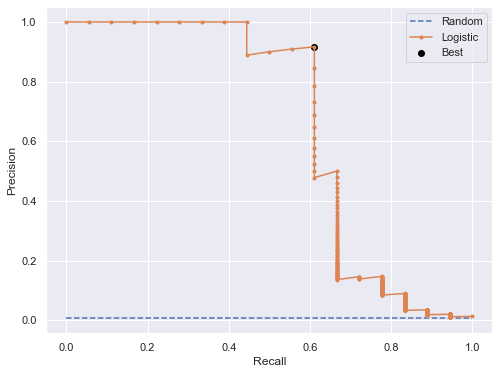

In [53]:
# convert to f score
f1 = (2*recall*precision) / (recall+precision)
# locate the index of the largest f score
ix = np.argmax(f1)

print(f'Best Threshold: {thresholds[ix]}, F1-Score: {f1[ix]:.3f}')

no_skill = len(y_valid[y_valid==1]) / len(y_valid)

# plot the roc curve for the model
plt.figure(figsize=(8, 6))
plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='Random')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt;

# Optimal Threshold Tuning for F1-Score

In [68]:
from sklearn.metrics import f1_score

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
# predict labels
preds_lr = lr.predict(X_valid)

# evaluate the model
f1 = f1_score(y_valid, preds_lr)
print(f'F1-Score: {f1:.5f}')

F1-Score: 0.61538


##  Tuning the threshold for the logistic regression model on the synthetic imbalanced classification dataset

In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype('int')

# fit a model
lr = LogisticRegression(solver='lbfgs')

lr.fit(X_train, y_train)
# predict probabilities
probs_lr = lr.predict_proba(X_valid)
# keep probabilities for the positive outcome only

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_valid, probs_lr[:, 1])

no_skill = len(y_valid[y_valid==1]) / len(y_valid)


# define thresholds
thres_range = np.arange(0, 1, 0.001)
print(f"Len of Range Thresholds: {len(thres_range)}")

# evaluate each threshold
f1_sc = [f1_score(y_valid, to_labels(probs_lr[:, 1], t)) for t in thres_range]

# get best threshold
ix = np.argmax(f1_sc)

print(f'Best Threshold: {thres_range[ix]:.5f}, F1-Score: {f1_sc[ix]:.5f}')

Len of Range Thresholds: 1000
Best Threshold: 0.33000, F1-Score: 0.73333


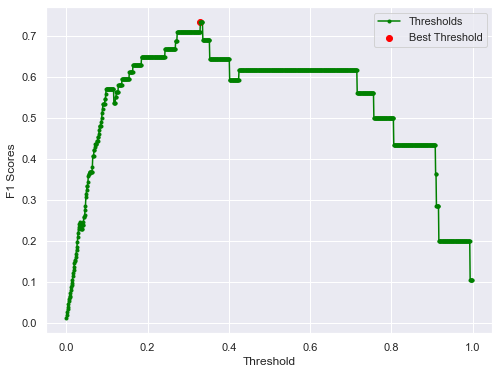

In [69]:
# plot the roc curve for the model
plt.figure(figsize=(8, 6))
# plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='Random')
# plt.plot(recall, precision, marker='.', label='Logistic')
plt.plot(thres_range, scores, marker='.', color='green', label='Thresholds')
plt.scatter(thres_range[ix], scores[ix], marker='o', color='red', label='Best Threshold')
# axis labels
plt.ylabel('F1 Scores')
plt.xlabel('Threshold')
plt.legend()
# show the plot
plt;

##  Comparison between old and new F1-Scores Values.

    modl.predict_proba(X_test)[:,0] is the probability of the label being 0 
    modl.predict_proba(X_test)[:,1] is the probability of the label being 1.

In [73]:
# Threshold Good
threshold = thres_range[ix]
print(threshold)
preds_lr_ = [1 if x >= threshold else 0 for x in probs_lr[:, 1]]
preds_lr_[:20]

0.33


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [72]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
# predict labels
preds_lr = lr.predict(X_valid)

# Comparison
  
# Old Precision Value
print("Old F1 Scores value:", f1_score(y_valid, preds_lr))
# New precision Value  
print("New F1 Scores value:", f1_score(y_valid, preds_lr_))

Old F1 Scores value: 0.6153846153846153
New F1 Scores value: 0.7333333333333334
